In [74]:
import numpy as np
import os
import h5py
import tomocam
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

In [69]:
class CTViewer:
    def __init__(self, vol):
        self.volume = vol
        self.index = 0
        self.fig, self.ax = plt.subplots()
        self.ax.imshow(self.volume[self.index])
        self.fig.canvas.mpl_connect('key_press_event', self.update)
        
    def set_clim(self, lims):
        self.ax.images[0].set_clim(lims)
        self.fig.canvas.draw()
        
    def update(self, event):
        if event.key == 'right':
            self.next_slice()
        elif event.key == 'left':
            self.prev_slice()
        elif event.key == 'up':
            self.jump_fwd()
        elif event.key == 'down':
            self.jump_back()
        self.fig.canvas.draw()
        
    def next_slice(self):
        self.index = (self.index + 1) % self.volume.shape[0]  # wrap around using %
        self.ax.images[0].set_array(self.volume[self.index])
        
    def prev_slice(self):
        self.index = (self.index - 1) % self.volume.shape[0]  # wrap around using %
        self.ax.images[0].set_array(self.volume[self.index])
            
    def jump_fwd(self):
        self.index = (self.index + 5) % self.volume.shape[0]  # wrap around using %
        self.ax.images[0].set_array(self.volume[self.index])
             
    def jump_back(self):
        self.index = (self.index - 5) % self.volume.shape[0]  # wrap around using %
        self.ax.images[0].set_array(self.volume[self.index])

In [70]:
sdir = '/data/tomochallange/phantom_00016/'
filename = 'phantom_00016.h5'

In [71]:
fp = h5py.File(os.path.join(sdir, filename), 'r')
data = fp['/projs']

# put data into sinogram format
s = np.array(data[:,:16,:].transpose(1,0,2))

# make sure to deep-copy
angs = np.array(fp['/angs'], copy=True)

<IPython.core.display.Javascript object>


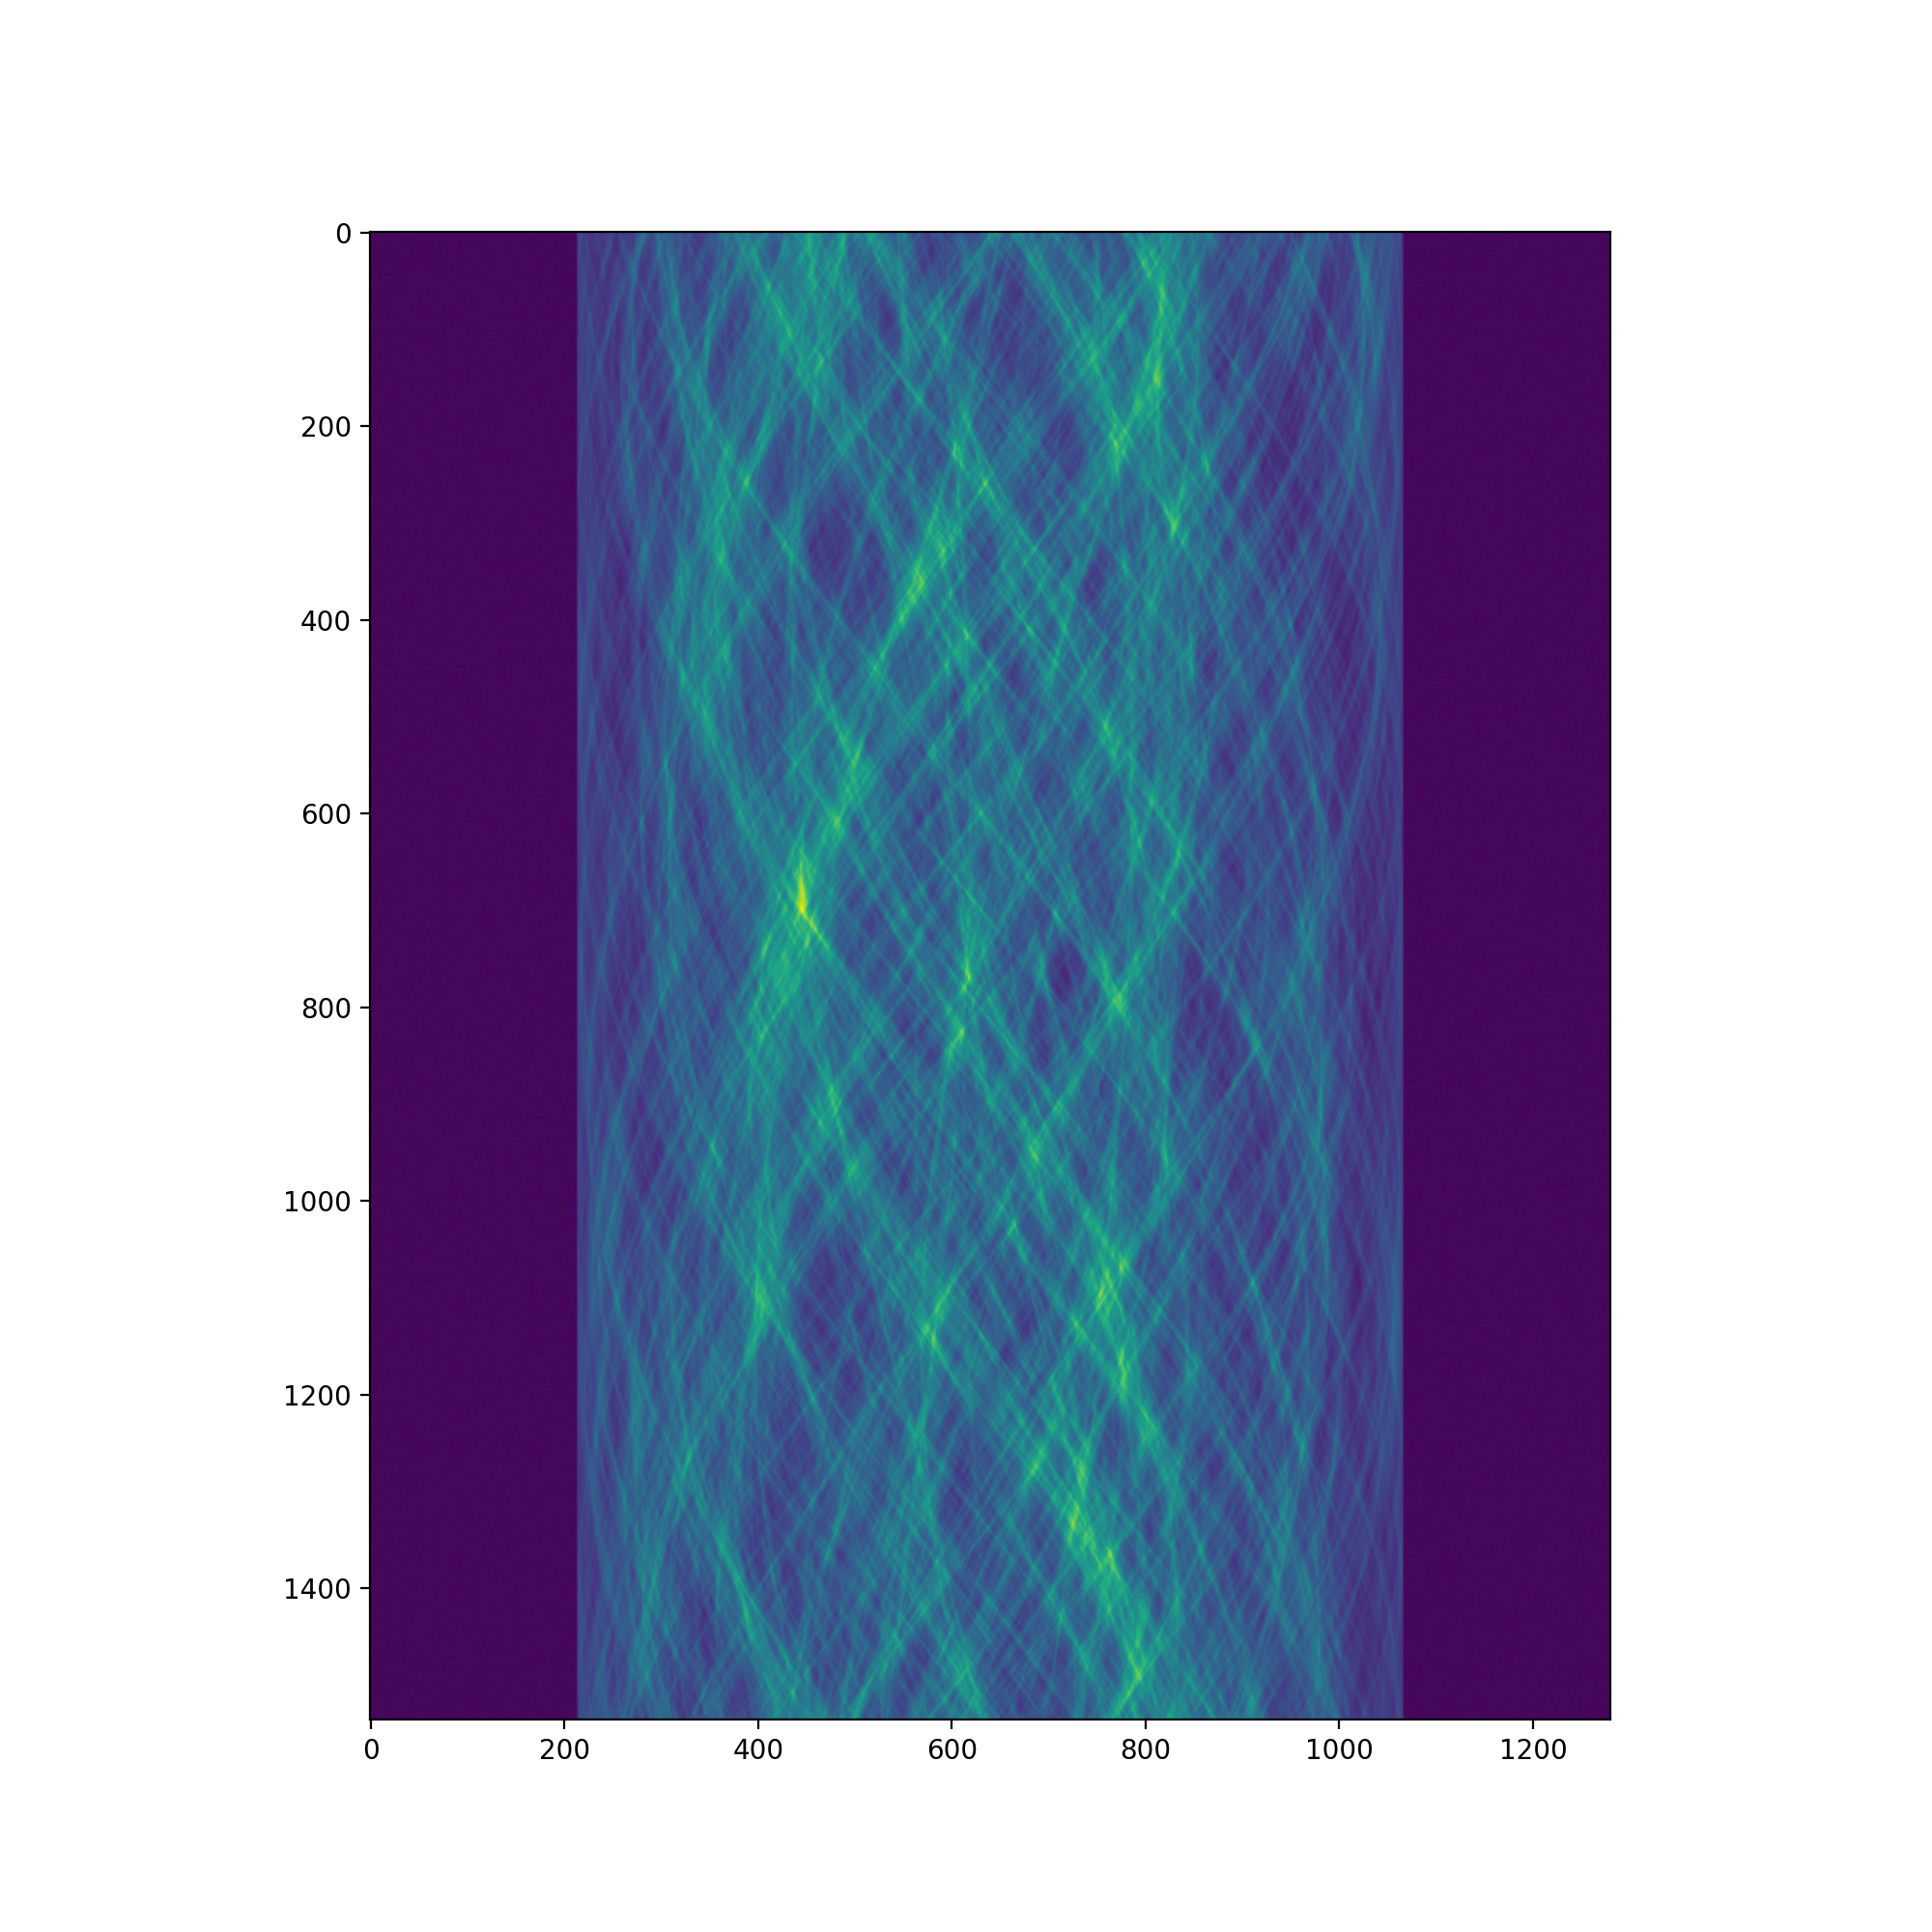

In [72]:
# plot for sanity check
img = CTViewer(s)

In [47]:
# create tomocam.DistArrays
nslc, nproj, nrow = s.shape
sino = tomocam.DistArray(s.copy())
model = tomocam.DistArray(np.ones((nslc, nrow, nrow), dtype=np.float32))

In [48]:
for itr in range(35):
    gradients = model.copy()
    tomocam.calc_gradients(gradients, sino, angs, center=640, over_sample=1.5)
    tomocam.update_total_variation(model, gradients)
    tomocam.axpy(-0.1, gradients, model)
    error = 0.1 * gradients.norm()
    print(error)

26078.409375000003
24297.6484375
22642.71875
21104.600000000002
19675.93125
18349.35625
17117.925
15975.1953125
14914.8640625
13931.690625000001
13020.715625
12177.02578125
11396.09765625
10673.403906250001
10005.3953125
9388.342968750001
8818.78515625
8293.58359375
7809.765625
7364.34375
6954.669531250001
6578.2015625
6232.82734375
5916.376171875
5626.58046875
5361.625390625
5119.492968750001
4898.630859375
4697.281640625
4513.9421875
4347.258984375
4195.84375
4058.438671875
3933.8855468750003
3821.071875


<IPython.core.display.Javascript object>


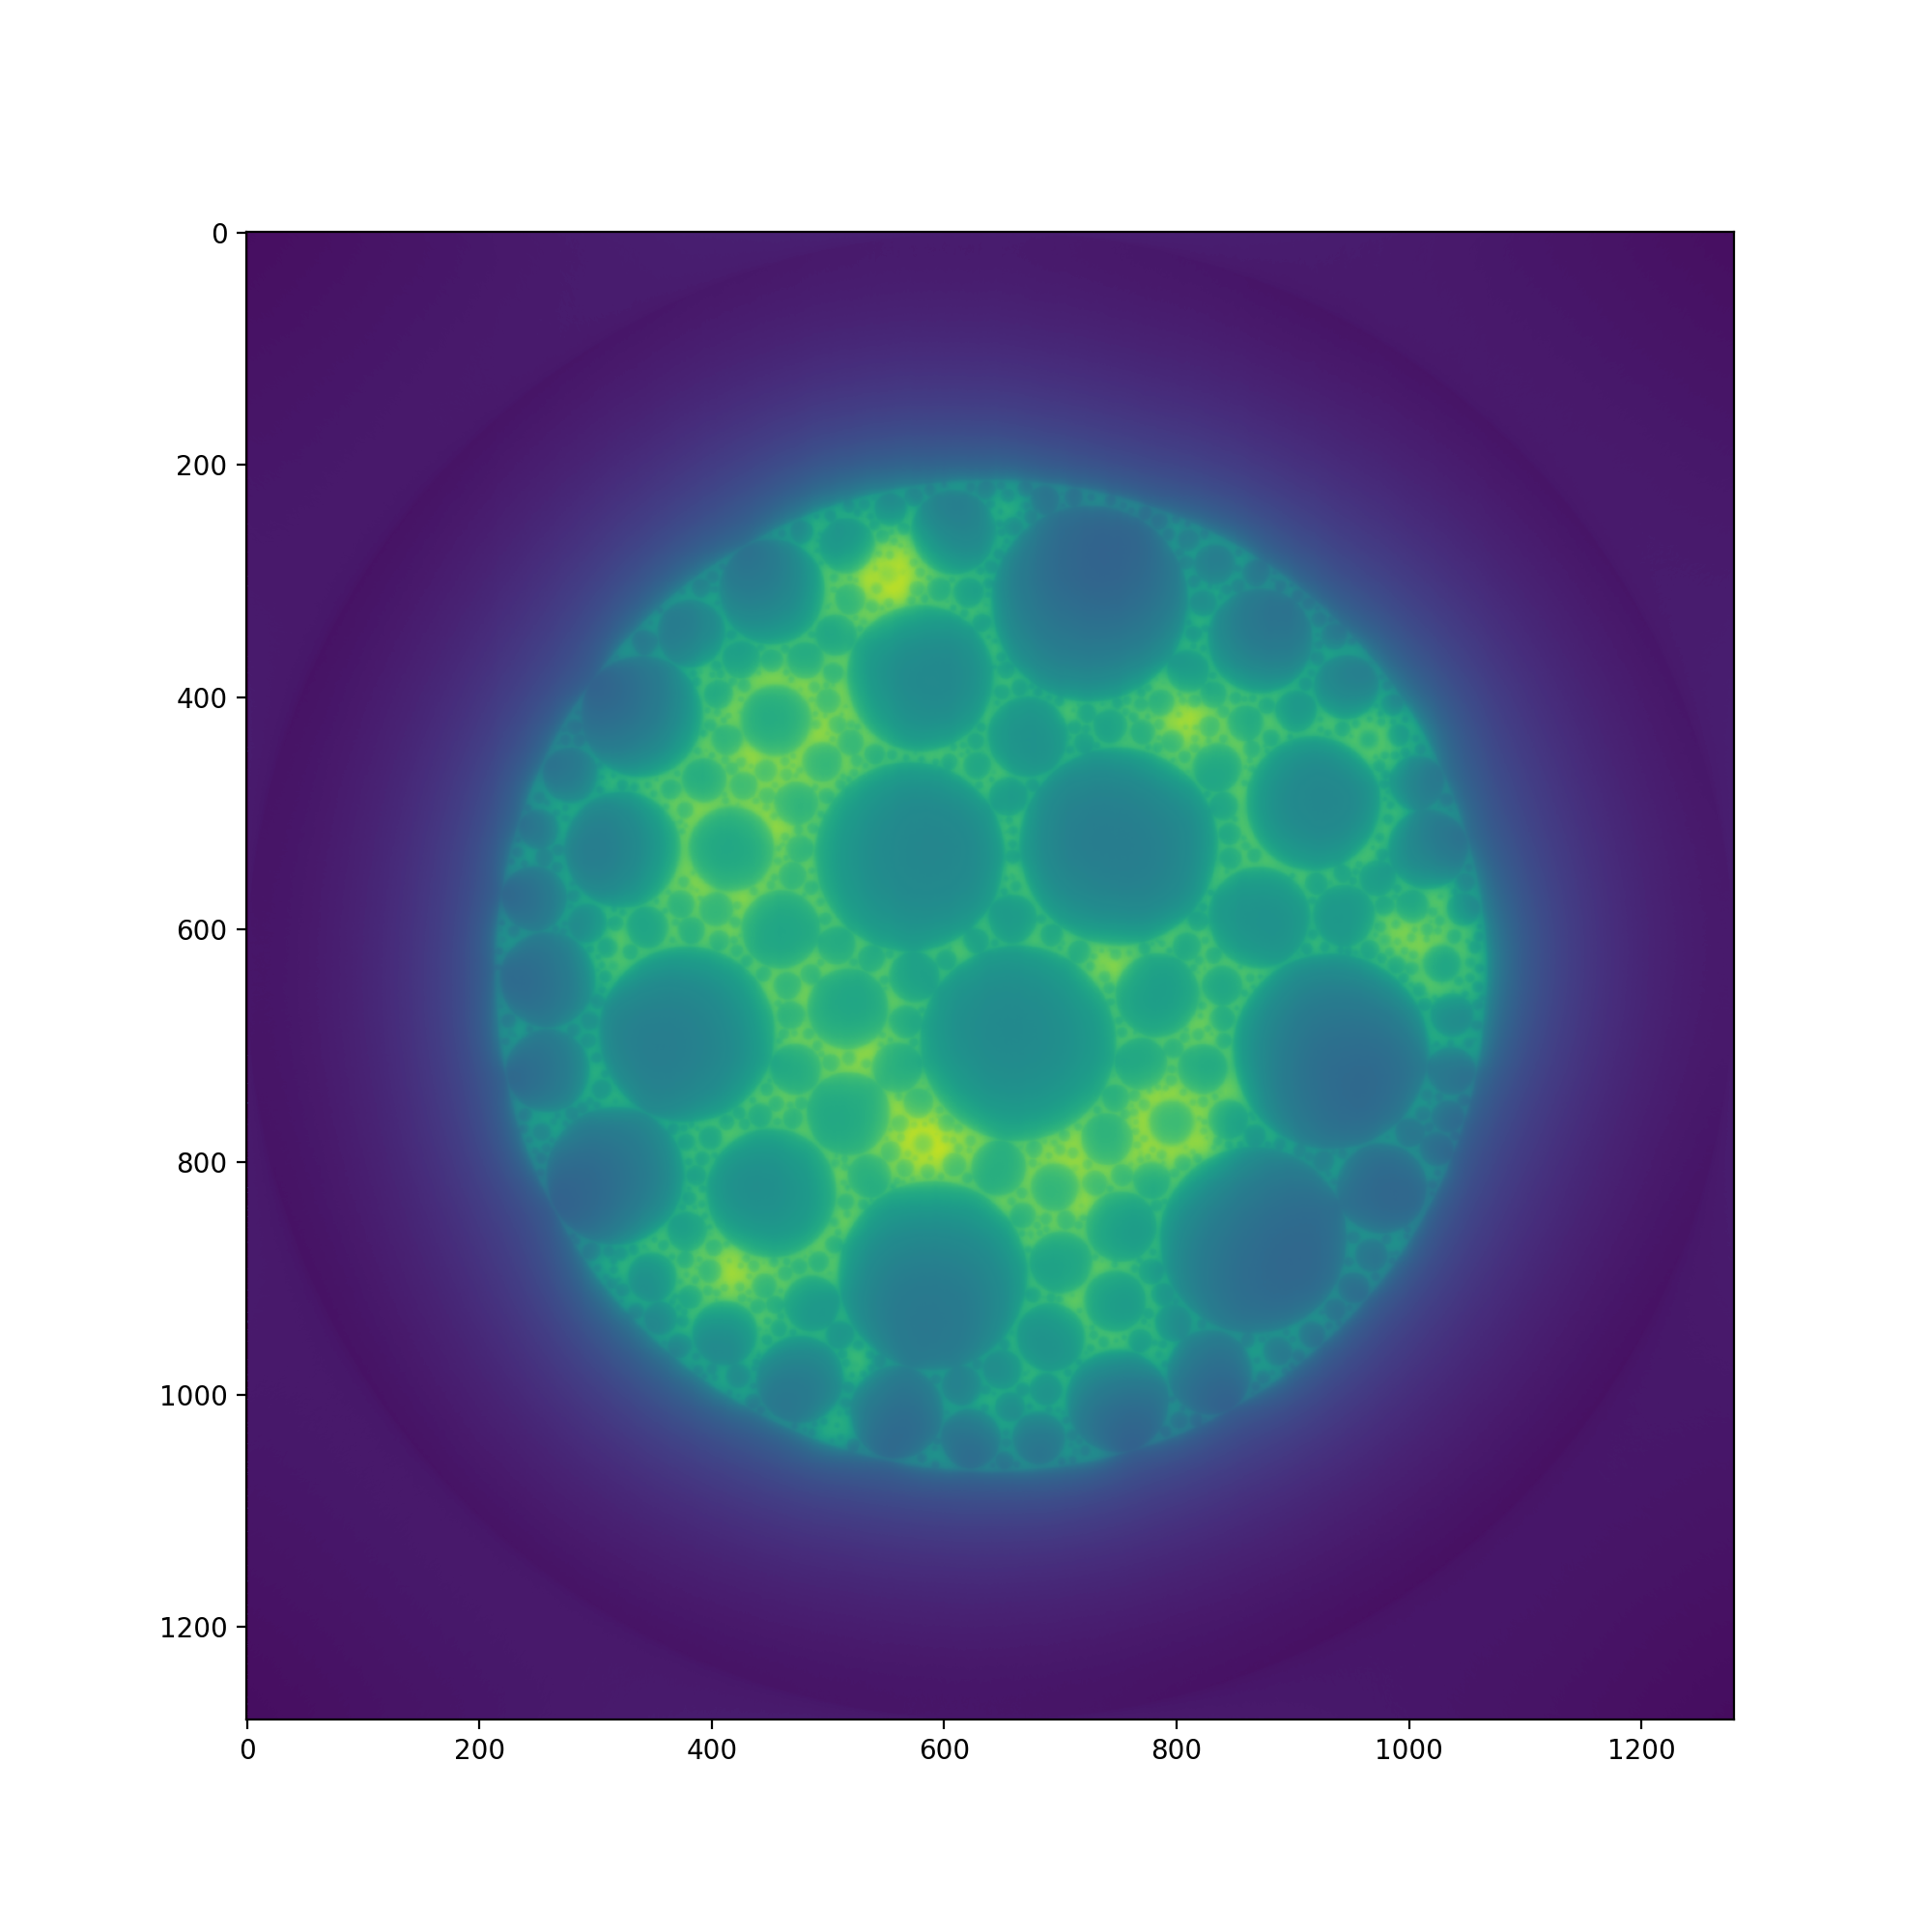

In [73]:
recon = model.to_numpy()
img2 = CTViewer(recon)
img2.set_clim([20, None])